## Computer Vision (EECE 7219) Assignment #1
### University of Memphis, Spring 2023
#### Instructor: Dr. Yeasin

Bereket Kebede, Gradaute Student, EECE

## Image Stitching

Objective: Combine two or more overlapping images to make one larger image

To do:
- to compute features (Interest points, blobs) using a simple difference of Gaussian (fun. 1)
- denoise the inconsistent points using RASAC (fun. 2)
- Find the corresponding points in images (fun. 3)
- Compute the Homography to Align Images (fun. 4)
- Blend Images to create a Mosaic or Panorama (fun. 5)

## Basic Idea 

- Warp images so that the corresponding points align
- RANSAC

General RANSAC Algorithm:

1. Randomly choose $s$ samples. Typically $s$ is the minimum samples to fit a model. 
2. Fit the model to the randomly chosen samples. 
3. Count the number $M$ of data points (inliners) that fit the model within a measure of error $\epsilon$.
4. Repeat 1 - 3 $N$ times
5. Choose the model that has the largest number M of inliners.

For homography:

$s$ = 4 points. $\epsilon$ is acceptable alignment error in pixels.


In [2]:
######################################
# import necessary libraries

import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt

In [3]:
######################################
# defining functions

class Stitch_Images():
    def __init__(self) :
        self.ratio=0.85
        self.min_match=10
        self.sift=cv2.xfeatures2d.SIFT_create()
        self.smoothing_window_size=800
        
    # fun. 1 
    def registration(self,img1,img2):
        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches=[]
        
        # fun. 3
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        cv2.imwrite('matching.jpg', img3)
        
        # fun. 2 & 4
        if len(good_points) > self.min_match:
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
        return H

    def create_mask(self,img1,img2,version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version== 'left_image':
            mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])
    
    # fun. 5
    def blending(self,img1,img2):
        H = self.registration(img1,img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1,img2,version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1,img2,version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
        result=panorama1+panorama2

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        return final_result
def stitch_two(argv1,argv2):
#     img1 = cv2.imread(argv1)
#     img2 = cv2.imread(argv2)
    img1 = cv2.cvtColor(cv2.imread(argv1), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(argv2), cv2.COLOR_BGR2RGB)
    final = Stitch_Images().blending(img1,img2)
    #final_2 = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
    plt.imshow(final/255)
    #cv2.imwrite('panorama.jpg', final)

In [4]:
left_image = cv2.imread('images/q3.jpg')
left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
right_image = cv2.imread('images/q4.jpg')
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'right_image')

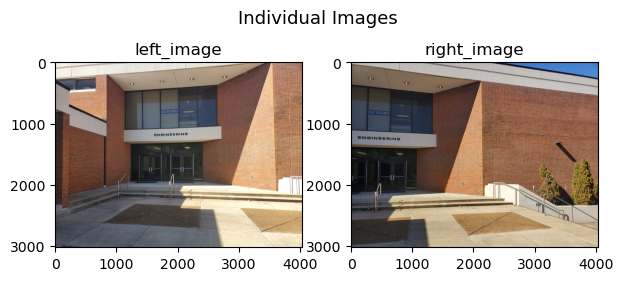

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

imgs = []

imgs.append(left_image)
imgs.append(right_image)

plt.suptitle('Individual Images', fontsize=13)

axes.flatten()[0].set_title('Original Image')
for ax, img in zip(axes.flatten(), imgs):
    ax.imshow(img)
    
axes.flatten()[0].set_title('left_image')
axes.flatten()[1].set_title('right_image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'panorama')

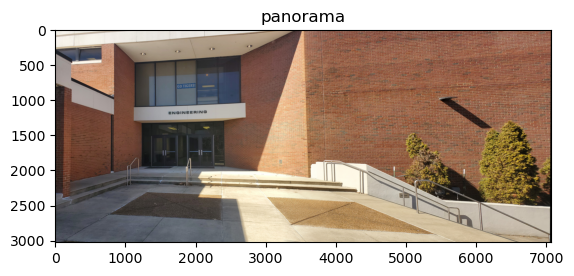

In [7]:
stitch_two('images/q3.jpg','images/q4.jpg')
plt.title('panorama')

Text(0.5, 1.0, 'drawing matches')

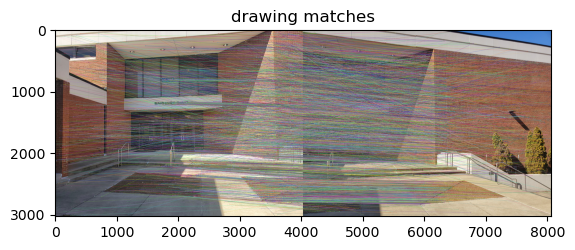

In [8]:
plt.imshow(cv2.imread('matching.jpg'))
plt.title('drawing matches')

In [9]:
# Reference

# https://github.com/linrl3/Image-Stitching-OpenCV/blob/new/Image_Stitching.py

#i.e.
# install the correct version of cv to use SIFT library
# pip install opencv-contrib-python